# PATTERN & HYPO tools


In [3]:
import numpy as np
import pandas as pd
from numpy.random import randn
np.random.seed(101)
DATA_DIR = '/Users/nathanzhao/Desktop/Python_quant_finance' + \
        '/Python-for-Finance-Repo-master-master' + \
        '/08-Time-Series-Analysis' 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [9]:
df = sm.datasets.macrodata.load_pandas().data
index = pd.Index(sm.tsa.datetools.dates_from_range  ('1959Q1','2009Q3'))
df.index = index

# Catalog:
* ### Binplots VA1, w/ DF partitioned by VA2

================================================
================================================

In [15]:
df.describe()
df.corr()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
year,1.000000,-0.011356,0.984331,0.979991,0.942204,0.861450,0.986156,0.988215,0.973572,-0.174020,0.042711,0.997223,-0.140837,-0.002373
quarter,-0.011356,1.000000,0.006082,0.005494,0.007072,0.012144,0.005984,0.005042,0.005237,0.011246,-0.004166,0.008334,-0.002453,0.021856
realgdp,0.984331,0.006082,1.000000,0.999229,0.977708,0.868651,0.999008,0.986524,0.978696,-0.275745,-0.064297,0.993297,-0.191880,-0.048492
realcons,0.979991,0.005494,0.999229,1.000000,0.976290,0.870713,0.999091,0.983735,0.976946,-0.294004,-0.056163,0.990350,-0.198804,-0.059517
realinv,0.942204,0.007072,0.977708,0.976290,1.000000,0.794797,0.971564,0.947084,0.933281,-0.273622,-0.185347,0.957720,-0.192416,-0.046433
realgovt,0.861450,0.012144,0.868651,0.870713,0.794797,1.000000,0.872241,0.882714,0.890436,-0.302875,-0.024619,0.861811,-0.295641,0.049280
realdpi,0.986156,0.005984,0.999008,0.999091,0.971564,0.872241,1.000000,0.986721,0.977752,-0.270082,-0.030797,0.994238,-0.186683,-0.048834
cpi,0.988215,0.005042,0.986524,0.983735,0.947084,0.882714,0.986721,1.000000,0.988812,-0.236846,0.024727,0.990182,-0.222361,0.028676
m1,0.973572,0.005237,0.978696,0.976946,0.933281,0.890436,0.977752,0.988812,1.000000,-0.330426,-0.016397,0.979025,-0.267236,-0.015337
tbilrate,-0.174020,0.011246,-0.275745,-0.294004,-0.273622,-0.302875,-0.270082,-0.236846,-0.330426,1.000000,0.229969,-0.217566,0.620508,0.298516


# Binplots VA1, w/ DF partitioned by VA2

In [185]:
def BINPLOT_VA1_parted_eq_by_VA2(
        df, 
        num_q, 
        va1, 
        va2, 
        va2_is_index = False, 

        apply_float_precision = True,
        precision_x_axis = 2,
        fig_size = (16,4),
        show_x_ticks = True
    ): 
    """
    Params:
        【va2_is_index】 True:
                Then 【va2】 is just a name of x axis
        【apply_float_precision】 True: 
                Only when 【va2】 is float/int
    Note:
        Require no repeating index, for time series index, 
            consider push repeating index by 1ns, repeat 
            until no repetition left.
    """
    # TODO:  Implement smart remove of repeat index
    if va2_is_index:
        unstacked = df[va1].groupby(pd.qcut(df.index, q = num_q)).apply(pd.DataFrame)
    else:
        unstacked = df[va1].groupby(pd.qcut(df[va2], q = num_q)).apply(pd.DataFrame)
        
    ax = pd.DataFrame(unstacked.values).plot(kind='box',figsize = fig_size)
    
    if apply_float_precision:
        precision_str = "{:." + str(precision_x_axis) + "f}"
        columns_interval_left = list(map(lambda x : precision_str.format(x.left), list(unstacked.columns)))
    else :
        columns_interval_left = list(map(lambda x : x.left, list(unstacked.columns)))
    if show_x_ticks:
        _ = ax.set_xticklabels(columns_interval_left)
    _ = ax.set_xlabel("LEFT of {" + va2 + "}")
    _ = ax.set_ylabel(va1)

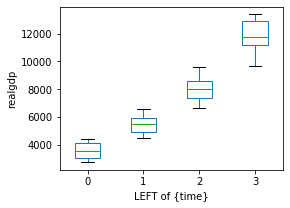

In [184]:
BINPLOT_VA1_parted_eq_by_VA2(
    df= df, 
    va1=  'realgdp', 
    va2 = 'time', 
    num_q =4, 
    va2_is_index = True, 
    apply_float_precision = False,
    fig_size = (4,3), 
    show_x_ticks = False
)